In [1]:
import logging
import time
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

%matplotlib inline

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bstuserver/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv('data-texts.txt', quotechar='"', escapechar='\\', names=['text', 'tag'])
df = df[pd.notnull(df['tag'])]
df.head(10)

,text,tag
0,Треугольный участок в таврово 15 между улицами...,0
1,"По указанному адресу до сих пор ямы, никто нич...",1
2,Обращаюсь по этому поводу не первый раз. ПСК п...,2
3,Прошу разобраться с этими бордюрами или отмост...,3
4,"Живу по указанному адресу более 2х лет, а фаса...",4
5,"На детской площадке по указанному адресу, давн...",5
6,"Недавно поднимал эту тему, она была решена, но...",5
7,Просим надзорные органы в сфере ЖКХ провести п...,6
8,Добрый день. В районе мини рынка Солнечный опя...,7
9,п.Уразово Валуйский городской округ 1)Недавно ...,8


In [4]:
df['text'].apply(lambda x: len(x.split(' '))).sum()

266364

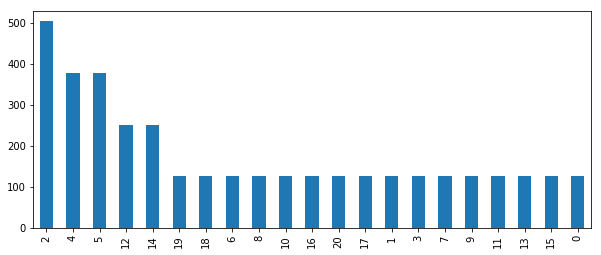

In [5]:
my_tags = list(map(str, range(21)))
plt.figure(figsize=(10,4))
df.tag.value_counts().plot(kind='bar');

In [6]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9а-я #+_]')
STOPWORDS = set(stopwords.words('russian'))

def clean_text(text):
    """
        text: a string        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [7]:
df['text'] = df['text'].apply(clean_text)

In [8]:
df['text'].apply(lambda x: len(x.split(' '))).sum()

182196

In [9]:
df.head(10)

,text,tag
0,треугольный участок таврово 15 улицами комсомо...,0
1,указанному адресу сих пор ямы никто исправлял ...,1
2,обращаюсь этому поводу первый пск жилью справл...,2
3,прошу разобраться этими бордюрами отмосткой не...,3
4,живу указанному адресу 2х лет фасад дома сторо...,4
5,детской площадке указанному адресу давным давн...,5
6,недавно поднимал тему решена фотографий отчете...,5
7,просим надзорные органы сфере жкх провести про...,6
8,добрый день районе мини рынка солнечный образо...,7
9,пуразово валуйский городской округ 1 недавно п...,8


In [10]:
import pickle

def dump_model(model):
    timestamp = int(time.time())
    with open('model-{timestamp}.sav'.format(timestamp=timestamp), 'wb') as f:
        pickle.dump(model, f)

def load_model(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [11]:
X = df.text
y = df.tag
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

### Logistic regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
model.fit(X_train, y_train)

/home/pv/PV-41/KaratachSergey/sr/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/pv/PV-41/KaratachSergey/sr/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=100000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [13]:
%%time
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))
[(type(x), x.shape) for x in (X_train, X_test, y_train, y_test)]

accuracy 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00        42
           2       1.00      1.00      1.00       153
           3       1.00      1.00      1.00        41
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       112
           6       1.00      1.00      1.00        40
           7       1.00      1.00      1.00        36
           8       1.00      1.00      1.00        37
           9       1.00      1.00      1.00        36
          10       1.00      1.00      1.00        45
          11       1.00      1.00      1.00        38
          12       1.00      1.00      1.00        81
          13       1.00      1.00      1.00        34
          14       1.00      1.00      1.00        59
          15       1.00      1.00      1.00        43
          16       1.00      1.00      1.00        47
          17  

[(pandas.core.series.Series, (2646,)),
 (pandas.core.series.Series, (1134,)),
 (pandas.core.series.Series, (2646,)),
 (pandas.core.series.Series, (1134,))]

In [14]:
df[:][1000:1025]

,text,tag
1000,покос сорняков осуществлялся добросовестно поэ...,9
1001,неоднократно обращались управляющую компанию у...,2
1002,17072019 года выйдя квартиры обнаружены разруш...,2
1003,23072019 года около 13 часов дня подаче горяче...,2
1004,указанному адресу газонах возле магазина магни...,10
1005,указанному адресу втором подъезде сильных дожд...,4
1006,указанному адресу проблема двора такие пандусы...,4
1007,указанному адресу козырьком спуске тех помещен...,11
1008,указанному выше адресу тротуар становится хуже...,12
1009,старый оскол детская стоматологическая поликли...,13


In [15]:
model.predict(X[1000:1025])

array([ 9,  2,  2,  2, 10,  4,  4, 11, 12, 13, 14, 15, 16, 14, 17, 18, 19,
       12,  5, 20,  0,  1,  2,  3,  4])

In [16]:
dump_model(model)

In [17]:
# model = load_model('model-1564272637.sav')

In [18]:
# del model

In [21]:
model.predict(pd.DataFrame(data={'text': ['украли сорняк из шкафа.']})['text'])

array([9])

In [22]:
model.predict(pd.DataFrame(data={'text': ['Южное,асфальта который он обещал возле дома 7,ул Мокроусова так и нет,крыша течет,межпанельные швы тоже,капремонт перенесли на 21-22года,а что можно сделать снять его нельзя,заменить тоже,поэтому ждём,когда начнут арену волейбольную строить пойдем просить.']})['text'])

array([4])